Overview

We crawled a website with a large blog using urlprofiler to extract key features of each blog post.  We matched this data with the dependent variable: page visitors 'GA Entrances' from Google Analytic.
The analysis aimed to use an ML model to: 
a) Determing the key features of a blog post in generating traffic to a website
b) predict traffic for new blog posts based on past blog performance

Table of Contents:

1. Import libraries & Data File
2. Initial Preprocessing 
    - Dealing with NaN values
    - removing irrelevant columns & columns to similar to dependent variable
    - adding date information with fastai
    - converting variables to relevant format ie seconds
3. Fast Random Forest to determine feature importance
    - determine rmse for the average prediction (for comparison purposes)
    - rerun RF on best features only to compare score
4. Deeper feature analysis for insights on original data
    - Drop more columns
    - review dependent variable
    - remove outliers
    - rerun algorithm
    - 4.b rereview the average prediction
5. Convert to binary classifier problem
    - anything above 200 visits considered a 1.
    - 5b review against a '0' prediction
6. Neural Network Model
    - a. Deep
    - b. Shallow & wide
    - c. Classifier version


# 1. Import libraries & data

In [1]:
#mport keras after fastai library.
from matplotlib import pyplot

from sklearn.preprocessing import MinMaxScaler
import tensorflow as tf

from keras.models import Sequential #import the Sequential model type from Keras. This is simply a linear stack of neural network layers, and it's perfect for the type of feed-forward CNN we're building in this tutorial.
from keras.layers import Dense, Dropout, Activation, Flatten
from keras.wrappers.scikit_learn import KerasRegressor
from keras.utils import np_utils
from keras.callbacks import EarlyStopping, ModelCheckpoint

from sklearn.model_selection import train_test_split

import pandas as pd
import numpy as np

from fastai.imports import *
from fastai import *
from fastai.structured import *

Using TensorFlow backend.


In [2]:
%time df_raw = pd.read_csv(open("C:/Users/Mark/Google Drive/python-files/files/content-ai/url_profile_results_190216105342.csv"), encoding='utf-8', engine='c',low_memory=False, parse_dates = ['Last Modified Date'])  
#data is imported from url_profiler

Wall time: 379 ms


In [3]:
df_raw.info(verbose=True, null_counts=True)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4436 entries, 0 to 4435
Data columns (total 239 columns):
URL                                                     4436 non-null object
Last Modified Date                                      4436 non-null datetime64[ns]
DNS Safe URL                                            4436 non-null object
Path                                                    4436 non-null object
Domain                                                  4436 non-null object
Root Domain                                             4436 non-null object
TLD                                                     4436 non-null object
Scheme                                                  4436 non-null object
HTTP Status Code                                        4436 non-null int64
HTTP Status                                             4436 non-null object
Original URL                                            4436 non-null object
Original HTTP Status Code             

In [9]:
#df_raw.head()

# 2. Preprocessing

In [5]:
#review NA columns
print(df_raw.isnull().sum().sort_values(ascending=False))

Keyword 7 Search Volume              4436
Keyword 10 Search Volume             4436
Keyword 9 Search Volume              4436
Keyword 1 Search Volume              4436
Keyword 2 Search Volume              4436
Keyword 3 Search Volume              4436
Keyword 4 Search Volume              4436
Keyword 5 Search Volume              4436
Keyword 6 Search Volume              4436
Keyword 8 Search Volume              4436
Unnamed: 238                         4435
Hash                                 4364
Unnamed: 237                         4358
Keyword 10 Position (SA)             1952
Keyword 10 CTR % (SA)                1952
Keyword 10 Impressions (SA)          1952
Keyword 10 Clicks (SA)               1952
Keyword 10 (SA)                      1952
Keyword 9 CTR % (SA)                 1856
Keyword 9 Position (SA)              1856
Keyword 9 Impressions (SA)           1856
Keyword 9 Clicks (SA)                1856
Keyword 9 (SA)                       1856
Keyword 8 Clicks (SA)             

In [6]:
# drop all columns that have mostly NA's in them, (fastai proc_df doesn't do this) but, good practice to do this anyway
df_train = df_raw.dropna(axis=1, how='all', thresh=200) #keep only columns that have at least 200 non-NA's
print(df_train.isnull().sum().sort_values(ascending=False))

Keyword 10 Position (SA)             1952
Keyword 10 CTR % (SA)                1952
Keyword 10 Impressions (SA)          1952
Keyword 10 Clicks (SA)               1952
Keyword 10 (SA)                      1952
Keyword 9 Impressions (SA)           1856
Keyword 9 Position (SA)              1856
Keyword 9 CTR % (SA)                 1856
Keyword 9 Clicks (SA)                1856
Keyword 9 (SA)                       1856
Keyword 8 Clicks (SA)                1746
Keyword 8 (SA)                       1746
Keyword 7 Position (SA)              1622
Keyword 7 CTR % (SA)                 1622
Keyword 7 Impressions (SA)           1622
Keyword 7 Clicks (SA)                1622
Keyword 7 (SA)                       1622
Keyword 6 Impressions (SA)           1482
Keyword 6 Clicks (SA)                1482
Keyword 6 (SA)                       1482
Keyword 6 CTR % (SA)                 1482
Keyword 6 Position (SA)              1482
PageSpeed Mobile Url                 1470
Mobile Friendly Score             

Wall time: 116 ms


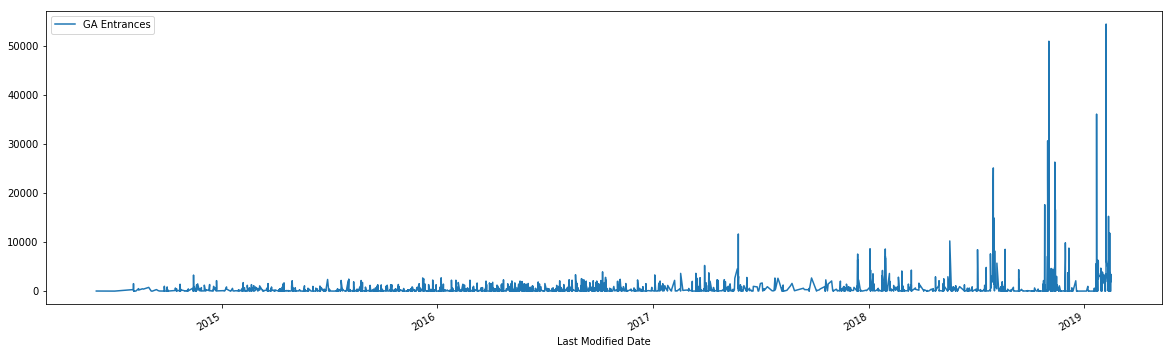

In [7]:
#review how far back the series goes
%time df_train.plot(x='Last Modified Date', y='GA Entrances', figsize=(20,6))

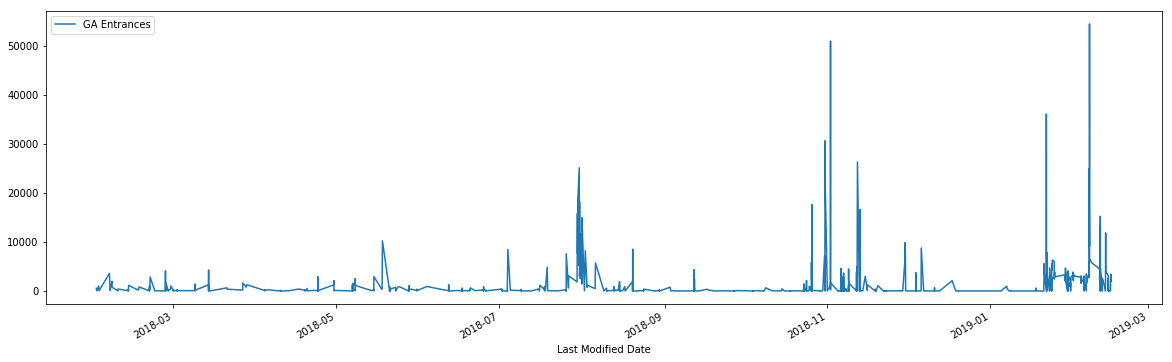

In [8]:
#it's too far back, & the data clearly changes after jan 2018. try taking just from Jan 2018
df_train = df_train[(df_train['Last Modified Date'] > '2018-01-31')]
df_train.plot(x='Last Modified Date', y='GA Entrances', figsize=(20,6))

In [12]:
#feature engineering
#first lets add dateparts to all of the data to give us more information
%time add_datepart(df_train, 'Last Modified Date', drop=True, time=True) 

Wall time: 101 ms


In [13]:
df_train.info(verbose=True, null_counts=True)

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1461 entries, 2975 to 4435
Data columns (total 241 columns):
URL                                                     1461 non-null object
DNS Safe URL                                            1461 non-null object
Path                                                    1461 non-null object
Domain                                                  1461 non-null object
Root Domain                                             1461 non-null object
TLD                                                     1461 non-null object
Scheme                                                  1461 non-null object
HTTP Status Code                                        1461 non-null int64
HTTP Status                                             1461 non-null object
Original URL                                            1461 non-null object
Original HTTP Status Code                               1461 non-null int64
Original HTTP Status                        

In [15]:
#convert 'GA Average Time on Page' into seconds
df_train['GA Average Time on Page'] = pd.to_timedelta(df_train['GA Average Time on Page'], unit='s')
df_train['GA Time on Page'] = df_train['GA Average Time on Page'].dt.total_seconds()
df_train = df_train.drop(axis=1, columns=['GA Average Time on Page']) #drop the original since this wont work with algorithm.
df_train['GA Time on Page'].tail()

4431    290.0
4432      0.0
4433      0.0
4434    324.0
4435    235.0
Name: GA Time on Page, dtype: float64

In [16]:
#drop things that are too similar to dependent variable
columns_to_drop_part_one = ['GA Exits',
                   'GA Sessions',
                   'GA Users',
                   'GA New Users',
                   'GA Unique Page Views',
                   'GA Page Views',
                   'GA Entrance Rate',
                   'Total Keywords (SA)',
                   'Total Clicks (SA)', 
                   'Total Impressions (SA)',
                   'Keyword 10 Clicks (SA)', 
                   'Keyword 9 Clicks (SA)', 
                   'Keyword 8 Clicks (SA)',
                   'Keyword 7 Clicks (SA)',
                   'Keyword 6 Clicks (SA)',
                   'Keyword 5 Clicks (SA)',
                   'Keyword 4 Clicks (SA)',
                   'Keyword 3 Clicks (SA)',
                   'Keyword 2 Clicks (SA)',
                   'Keyword 1 Clicks (SA)',
'Keyword 10 Impressions (SA)',
'Keyword 9 Impressions (SA)',
'Keyword 8 Impressions (SA)',
'Keyword 7 Impressions (SA)',
'Keyword 6 Impressions (SA)',
'Keyword 5 Impressions (SA)',
'Keyword 4 Impressions (SA)',
'Keyword 3 Impressions (SA)',
'Keyword 2 Impressions (SA)',
'Keyword 1 Impressions (SA)',
                    'Keyword 10 CTR % (SA)',
                    'Keyword 10 Position (SA)',
                    'Keyword 9 CTR % (SA)',
                    'Keyword 9 Position (SA)',
                    'Keyword 8 CTR % (SA)',
                    'Keyword 8 Position (SA)',
                    'Keyword 7 CTR % (SA)',
                    'Keyword 7 Position (SA)',
                    'Keyword 6 CTR % (SA)',
                    'Keyword 6 Position (SA)',
                    'Keyword 5 CTR % (SA)',
                    'Keyword 5 Position (SA)',
                    'Keyword 4 CTR % (SA)',
                    'Keyword 4 Position (SA)',
                    'Keyword 3 CTR % (SA)',
                    'Keyword 3 Position (SA)',
                    'Keyword 2 CTR % (SA)',
                    'Keyword 2 Position (SA)',
                    'Keyword 1 CTR % (SA)',
                    'Keyword 1 Position (SA)',
'Keyword 1 (SA)',
'Keyword 2 (SA)',
'Keyword 3 (SA)',
'Keyword 4 (SA)',
'Keyword 5 (SA)',
'Keyword 6 (SA)',
'Keyword 7 (SA)',
'Keyword 8 (SA)',
'Keyword 9 (SA)',
'Keyword 10 (SA)',] 
df_train = df_train.drop(axis=1, columns=columns_to_drop_part_one)

In [17]:
df_train.info(verbose=True)

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1461 entries, 2975 to 4435
Data columns (total 181 columns):
URL                                                     object
DNS Safe URL                                            object
Path                                                    object
Domain                                                  object
Root Domain                                             object
TLD                                                     object
Scheme                                                  object
HTTP Status Code                                        int64
HTTP Status                                             object
Original URL                                            object
Original HTTP Status Code                               int64
Original HTTP Status                                    object
Content Type                                            object
Content Length                                          float64
Charset 

In [18]:
print(df_train.isnull().sum().sort_values(ascending=False))

Mobile Friendly Score                               1398
Uses Incompatible Plugins                           1398
Content Wider Than Screen                           1398
Links Too Close Together                            1398
Text Too Small To Read                              1398
Mobile Viewport Not Set                             1398
Robots.txt Blocked Resources                        1398
Resources Failed                                    1398
PageSpeed Mobile Url                                1398
Mobile Friendly Url                                 1390
PageSpeed Desktop Url                               1388
Average CTR % (SA)                                    26
Average Position (SA)                                 26
Author                                                14
Author URL                                            14
Sentiment                                             13
Word 10                                               13
Reading Time                   

In [19]:
#fill everything that is null with 0's.  Otherwise proc_df fills it with median value.  0's seem more appropriate as a sweeping gesture.
#df_train = df_train.fillna(value=0)  #imputing the mean value using proc_df worked better
print(df_train.isnull().sum().sort_values(ascending=False))

Mobile Friendly Score                               1398
Uses Incompatible Plugins                           1398
Content Wider Than Screen                           1398
Links Too Close Together                            1398
Text Too Small To Read                              1398
Mobile Viewport Not Set                             1398
Robots.txt Blocked Resources                        1398
Resources Failed                                    1398
PageSpeed Mobile Url                                1398
Mobile Friendly Url                                 1390
PageSpeed Desktop Url                               1388
Average CTR % (SA)                                    26
Average Position (SA)                                 26
Author                                                14
Author URL                                            14
Sentiment                                             13
Word 10                                               13
Reading Time                   

# 3. build fast RF to drefine features by importance

In [ ]:
df_quick_rf = df_train.copy() #making a copy for the quick rf - means we can keep df_train to work on again in part2

In [20]:
train_cats(df_quick_rf)
#apply_cats(X_test, trn=X_train)

In [21]:
#proc df on both train and test after the above

In [22]:
#seems that most people do proc_df before splitting into train/test/split
df, y , nas = proc_df(df_quick_rf, 'GA Entrances', max_n_cat=None)
#X_test,y_test,nas = proc_df(X_test, 'GA Entrances', na_dict=nas)  #only in this case, since we have actual data, but usually on a validation set, we wouldn't keep the 'item_count_day'
#X, y , nas = proc_df(df_train, 'item_cnt_day', na_dict=nas)

In [23]:
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(df, y, test_size=0.2, random_state=42) #dont actually need the 'y' at this stage, just using it to make this work.

In [24]:
#checking the shapes look right.
df_raw.shape, X_train.shape, y_train.shape, X_test.shape, y_test.shape

((4436, 239), (1168, 221), (1168,), (293, 221), (293,))

In [25]:
#fit random forest to the data
#set_rf_samples(3000)

from sklearn.ensemble import RandomForestRegressor
rf = RandomForestRegressor(n_estimators=50, max_depth = 20, min_samples_leaf=4, max_features=0.5, n_jobs=-1, oob_score=True)

%time rf_fit = rf.fit(X_train, y_train)
rf_predict = rf_fit.predict(X_test) #predictions

#calculate Root Mean Squared Error for predictions 'rf_predict' against actuals 'y_test'
from sklearn.metrics import mean_squared_error
mse = mean_squared_error(y_test, rf_predict)
rmsqe = np.sqrt(mse)
print("RMSQE: ", rmsqe)

Wall time: 525 ms
RMSQE:  1726.8435325858827


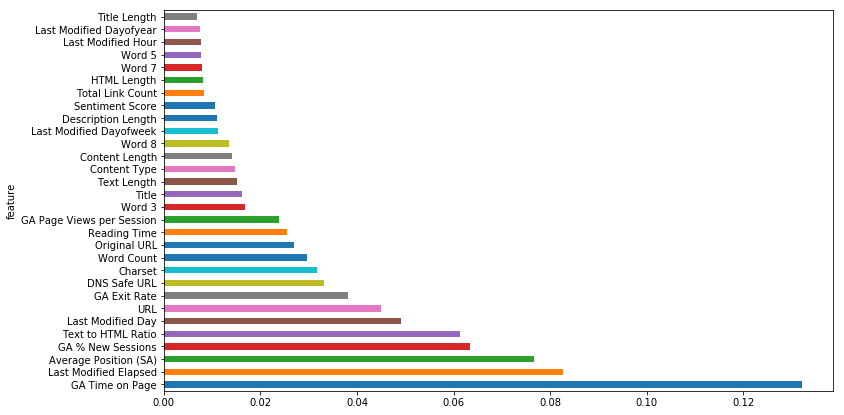

In [26]:
#----------feature importance

feat_labels = X_train.columns
importance = rf_fit.feature_importances_  #determing feature importance from the algorithm"

df_feat = pd.DataFrame(importance, index=feat_labels)
df_feat = df_feat.reset_index()
df_feat = df_feat.rename(index=str, columns={0: "importance", 'index': 'feature'})
df_feat = df_feat.sort_values('importance', ascending=False, inplace=False, axis=0)
df_feat.head(20)

#plotting feature importances
def plot_fi(df): 
  return df.plot('feature','importance','barh', figsize=(12,7), legend=False)
plot_fi(df_feat[:30]);

In [27]:
df_feat.head(20)

,feature,importance
179,GA Time on Page,0.132072
178,Last Modified Elapsed,0.082626
64,Average Position (SA),0.076713
57,GA % New Sessions,0.063495
18,Text to HTML Ratio,0.061315
166,Last Modified Day,0.049174
0,URL,0.044887
60,GA Exit Rate,0.038236
1,DNS Safe URL,0.033151
14,Charset,0.031804


In [28]:
#----
#what would happen if we predicted the average GA_Entrances for everything?
X_train['avg_GA_entrances'] = y_train.mean() #find the mean and create a new column in the training set.
X_train['avg_GA_entrances'].head()

C:\Users\Mark\Anaconda3\envs\fastai\lib\site-packages\ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  This is separate from the ipykernel package so we can avoid doing imports until


4041    943.900685
3613    943.900685
3774    943.900685
3355    943.900685
3278    943.900685
Name: avg_GA_entrances, dtype: float64

In [29]:
y_test.shape #work out how many rows in the test set

(293,)

In [30]:
y_avg_cnt = X_train['avg_GA_entrances'][:293].values #creat an array of that length

In [31]:
mse = mean_squared_error(y_test, y_avg_cnt)
rmsqe = np.sqrt(mse)
print("RMSQE: ", rmsqe) 

RMSQE:  1973.4065414073616


In [32]:
#so actually looks like my random forest is better then just taking the average!
#-----##

In [33]:
#creating new dataframe 'df_keep' with best features only
to_keep = df_feat[df_feat.importance>0.01].feature; len(to_keep)
df_keep = df[to_keep].copy()  #df is the original df where we did proc_df

X_train, X_test, y_train, y_test = train_test_split(df_keep, y, test_size=0.2, random_state=42)

df_keep.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1461 entries, 2975 to 4435
Data columns (total 23 columns):
GA Time on Page              1461 non-null float64
Last Modified Elapsed        1461 non-null int64
Average Position (SA)        1461 non-null float64
GA % New Sessions            1461 non-null float64
Text to HTML Ratio           1461 non-null float64
Last Modified Day            1461 non-null int64
URL                          1461 non-null int16
GA Exit Rate                 1461 non-null float64
DNS Safe URL                 1461 non-null int16
Charset                      1461 non-null int8
Word Count                   1461 non-null int64
Original URL                 1461 non-null int16
Reading Time                 1461 non-null int16
GA Page Views per Session    1461 non-null float64
Word 3                       1461 non-null int16
Title                        1461 non-null int16
Text Length                  1461 non-null int64
Content Type                 1461 non-null int

In [34]:
from sklearn.ensemble import RandomForestRegressor
rf = RandomForestRegressor(n_estimators=50, max_depth = 20, min_samples_leaf=6, max_features=0.5, n_jobs=-1, oob_score=True)

%time rf_fit = rf.fit(X_train, y_train)
rf_predict = rf_fit.predict(X_test) #predictions

#calculate Root Mean Squared Error for predictions 'rf_predict' against actuals 'y_test'
from sklearn.metrics import mean_squared_error
mse = mean_squared_error(y_test, rf_predict)
rmsqe = np.sqrt(mse)
print("RMSQE: ", rmsqe)

Wall time: 162 ms
RMSQE:  1469.1752584899723


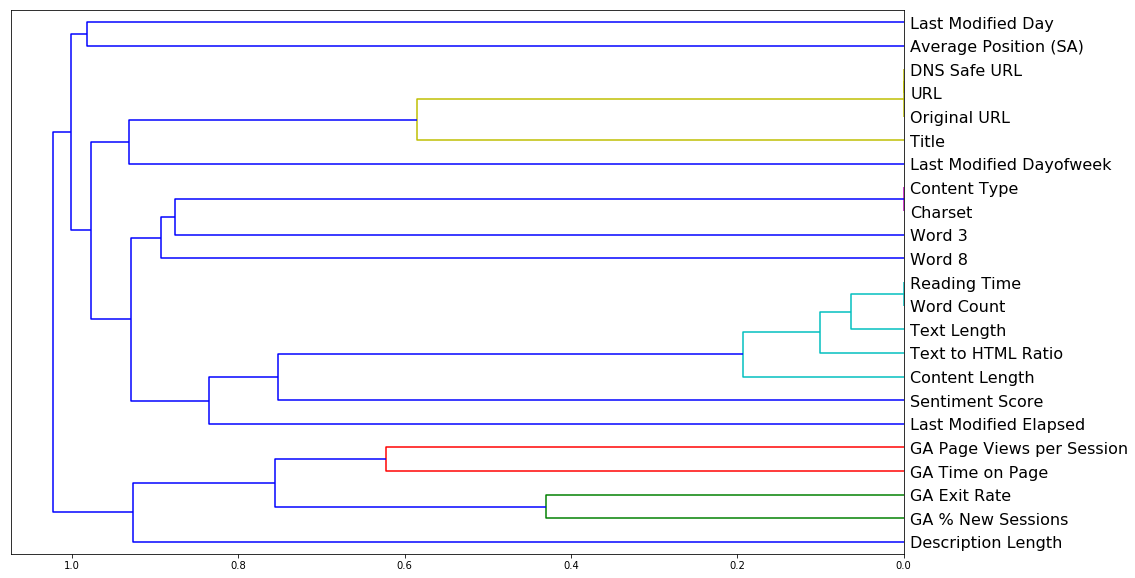

In [35]:
#cluster analysis to further find variables that are too similar using correlation between variables.
from scipy.cluster import hierarchy as hc
corr = np.round(scipy.stats.spearmanr(df_keep).correlation, 4)
corr_condensed = hc.distance.squareform(1-corr)
z = hc.linkage(corr_condensed, method='average')
fig = plt.figure(figsize=(16,10))
dendrogram = hc.dendrogram(z, labels=df_keep.columns, 
      orientation='left', leaf_font_size=16)
plt.show()
#things  closer to the right like fireplaces are variables are similar and need to be investigatedfurther

In [36]:
#drop these because they are too similar
to_drop = ['Charset', 'URL', 'DNS Safe URL', 'Reading Time', 'Text Length', 'Text to HTML Ratio']

In [37]:
df_keep.drop(to_drop, axis=1, inplace=True)
X_train, X_test, y_train, y_test = train_test_split(df_keep, y, test_size=0.2, random_state=42)

In [38]:
from sklearn.ensemble import RandomForestRegressor
rf = RandomForestRegressor(n_estimators=50, max_depth = 20, min_samples_leaf=6, max_features=0.5, n_jobs=-1, oob_score=True)

%time rf_fit = rf.fit(X_train, y_train)
rf_predict = rf_fit.predict(X_test) #predictions

#calculate Root Mean Squared Error for predictions 'rf_predict' against actuals 'y_test'
from sklearn.metrics import mean_squared_error
mse = mean_squared_error(y_test, rf_predict)
rmsqe = np.sqrt(mse)
print("RMSQE: ", rmsqe)

Wall time: 155 ms
RMSQE:  1381.511169552176


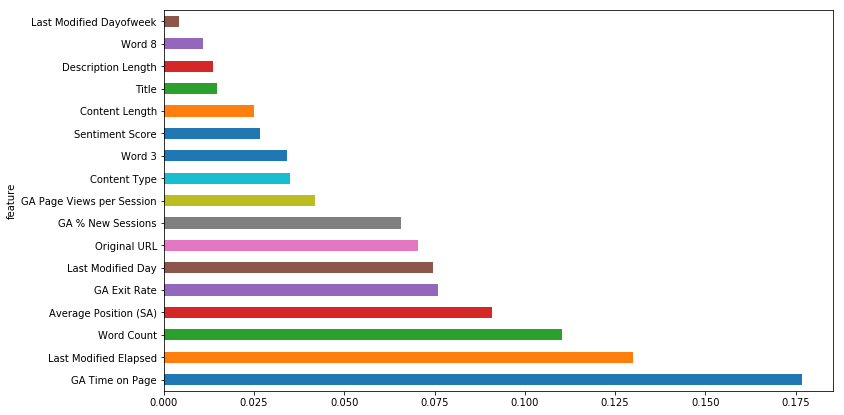

In [39]:
#----------feature importance

feat_labels = X_train.columns
importance = rf_fit.feature_importances_  #determing feature importance from the algorithm"

df_feat = pd.DataFrame(importance, index=feat_labels)
df_feat = df_feat.reset_index()
df_feat = df_feat.rename(index=str, columns={0: "importance", 'index': 'feature'})
df_feat = df_feat.sort_values('importance', ascending=False, inplace=False, axis=0)
df_feat.head(20)

#plotting feature importances
def plot_fi(df): 
  return df.plot('feature','importance','barh', figsize=(12,7), legend=False)
plot_fi(df_feat[:30]);

# 4. Deeper feature analysis for insights on original data

In [20]:
df_train_p2 = df_train.copy()

In [21]:
df_train_p2.info(verbose=True, null_counts=True)

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1461 entries, 2975 to 4435
Data columns (total 181 columns):
URL                                                     1461 non-null object
DNS Safe URL                                            1461 non-null object
Path                                                    1461 non-null object
Domain                                                  1461 non-null object
Root Domain                                             1461 non-null object
TLD                                                     1461 non-null object
Scheme                                                  1461 non-null object
HTTP Status Code                                        1461 non-null int64
HTTP Status                                             1461 non-null object
Original URL                                            1461 non-null object
Original HTTP Status Code                               1461 non-null int64
Original HTTP Status                        

In [22]:
#let's refine more columns
columns_to_drop_part_two = ['URL',
                            'Domain',
                            'Root Domain',
                    'DNS Safe URL',
                   'Path',
                   'Root Domain',
                   'HTTP Status',
                   'Original URL',                                            
'Original HTTP Status Code',                               
'Original HTTP Status',] 
df_train_p2 = df_train_p2.drop(axis=1, columns=columns_to_drop_part_two)


In [23]:
df_train_p2.shape

(1461, 172)

In [24]:
#------------------Mobile Speed Score
df_train_p2['Mobile Speed Score']

2975              36
2976              31
2977              33
2978              31
2979              33
2980    Check Failed
2981              31
2982              39
2983              31
2984              37
2985              38
2986              32
2987              35
2988              26
2989              38
2990              37
2991              33
2992              37
2993              36
2994              36
2995              36
2996              37
2997              35
2998              31
2999              38
3000              28
3001              39
3002              32
3003              30
3004              34
            ...     
4406               0
4407               0
4408               0
4409               0
4410               0
4411               0
4412               0
4413               0
4414               0
4415               0
4416               0
4417               0
4418               0
4419               0
4420               0
4421               0
4422         

In [25]:
#convert mobile speed score to integer
df_train_p2['Mobile Speed Score'] = pd.to_numeric(df_train_p2['Mobile Speed Score'], errors='coerce') #coerce because it has strings in it
df_train_p2['Mobile Speed Score'] = df_train_p2['Mobile Speed Score'].fillna(value=0) #convert na's that were strings to 0

In [26]:
#convert mobile speed score to integer
df_train_p2['Desktop Speed Score'] = pd.to_numeric(df_train_p2['Desktop Speed Score'], errors='coerce') #coerce because it has strings in it
df_train_p2['Desktop Speed Score'] = df_train_p2['Desktop Speed Score'].fillna(value=0) #convert na's that were strings to 0
df_train_p2['Desktop Speed Score']

2975    81.0
2976    86.0
2977    76.0
2978    86.0
2979    79.0
2980     0.0
2981    86.0
2982    87.0
2983    82.0
2984    87.0
2985    84.0
2986    77.0
2987    74.0
2988    72.0
2989    78.0
2990    73.0
2991    84.0
2992    83.0
2993    74.0
2994    72.0
2995    86.0
2996    77.0
2997    87.0
2998    86.0
2999    87.0
3000    74.0
3001    83.0
3002    87.0
3003    81.0
3004    85.0
        ... 
4406     0.0
4407     0.0
4408     0.0
4409     0.0
4410     0.0
4411     0.0
4412     0.0
4413     0.0
4414     0.0
4415     0.0
4416     0.0
4417     0.0
4418     0.0
4419     0.0
4420     0.0
4421     0.0
4422     0.0
4423     0.0
4424     0.0
4425     0.0
4426     0.0
4427     0.0
4428     0.0
4429     0.0
4430     0.0
4431     0.0
4432     0.0
4433     0.0
4434     0.0
4435     0.0
Name: Desktop Speed Score, Length: 1461, dtype: float64

In [27]:
#review the dependent variable
df_train['GA Entrances'].value_counts()
#df_train['GA Entrances'].describe()
#There are 310 pages where GA entrances = 0.  This is likely some kind of issue mayeb a robots block - worth looking into
#unsure as to whether to remove this from analyses.

0        310
7        126
14        74
21        68
27        46
41        44
34        34
48        32
62        26
55        24
75        21
82        16
116       16
68        16
130       15
89        13
137       13
109       13
103       12
157       11
198       11
150        9
96         8
212        7
280        6
356        6
232        6
308        6
205        6
191        6
        ... 
499        1
4369       1
4710       1
3473       1
629        1
1408       1
814        1
5449       1
30683      1
2844       1
16613      1
786        1
766        1
2803       1
1367       1
2789       1
4834       1
732        1
2776       1
718        1
23245      1
704        1
697        1
2742       1
1374       1
15273      1
2700       1
649        1
3446       1
2017       1
Name: GA Entrances, Length: 325, dtype: int64

In [3]:
#plot the value_counts
GA_Entrances  = df_train_p2['GA Entrances'].value_counts()
GA_Entrances = GA_Entrances[:20]

plt.figure(figsize=(10,5))
sns.barplot(GA_Entrances.index, GA_Entrances.values, alpha=0.8)
plt.title('GA Entrances vs Number of Pages')
plt.ylabel('Number of Pages', fontsize=12)
plt.xlabel('GA Entrances', fontsize=12)
plt.show()

NameError: name 'df_train_p2' is not defined

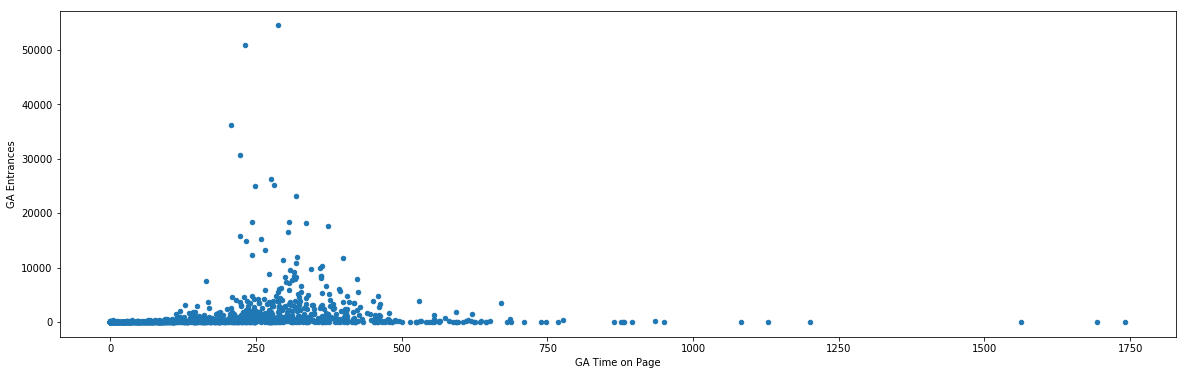

In [29]:
df_train_p2.plot(kind='scatter', x='GA Time on Page', y='GA Entrances', figsize=(20,6))

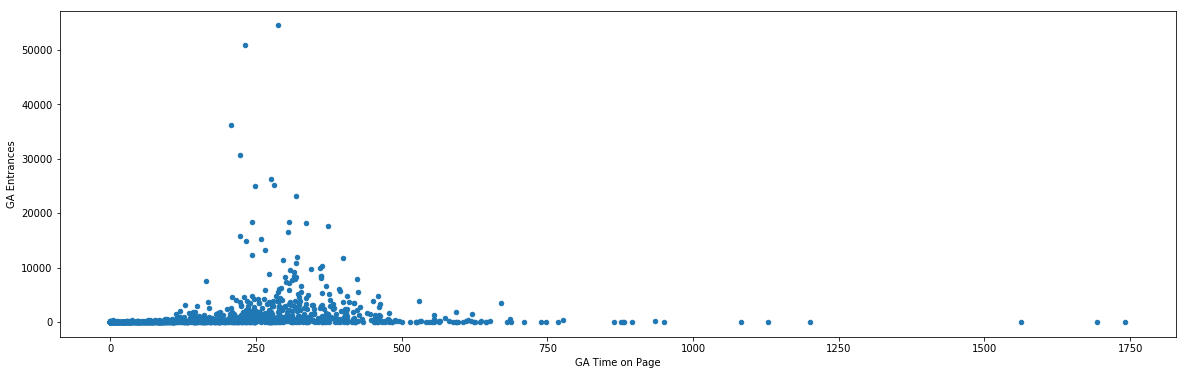

In [30]:
df_train_p2.plot(kind='scatter', x='GA Time on Page', y='GA Entrances', figsize=(20,6))
#remember that each row is a url(page), so need to view in terms of pages.
#appears to be a bell curve style relationship - pages where time on page around 200 to 300 seconds on page, get the most views.
#this tells us that ultra long content may not be ideal either
#those 2 pages that had huge traffic over 5k - miht be outliers - SHOULD REMOVE

In [31]:
df_train_p2 = df_train_p2[(df_train_p2['GA Entrances'] < 40000)] #let's chop off those high ones.

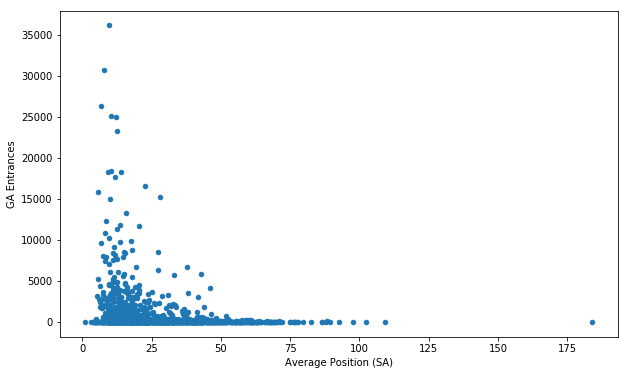

In [32]:
df_train_p2.plot(kind='scatter', x='Average Position (SA)', y='GA Entrances', figsize=(10,6))
#Strong relationship here.  How the page ranks, will determine its traffic - no real insight.
#but interesting to see that avg position 1, doesn't bring the most traffic - because on average content never ranks 1 all up. so not much there
#although there are some low rankers with no traffic - worth looking into?

C:\Users\Mark\Anaconda3\envs\fastai\lib\site-packages\ipykernel_launcher.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  after removing the cwd from sys.path.


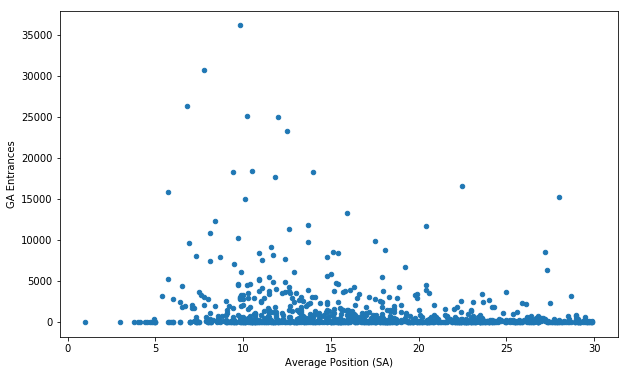

In [33]:
#zoom in closer to see whats happening at those low positions
df_train_plot = df_train_p2.copy() #create a new DF
df_train_plot = df_train_p2[(df_train_p2['Average Position (SA)'] < 30)] #limit the ave position
df_train_plot['GA Entrances']  = df_train_p2['GA Entrances']

df_train_plot.plot(kind='scatter', x='Average Position (SA)', y='GA Entrances', figsize=(10,6))

In [34]:
df_train_p2 = df_train_p2[(df_train_p2['Average Position (SA)'] > 0)] #removing the ones with avg position 0, it doesn't seem right

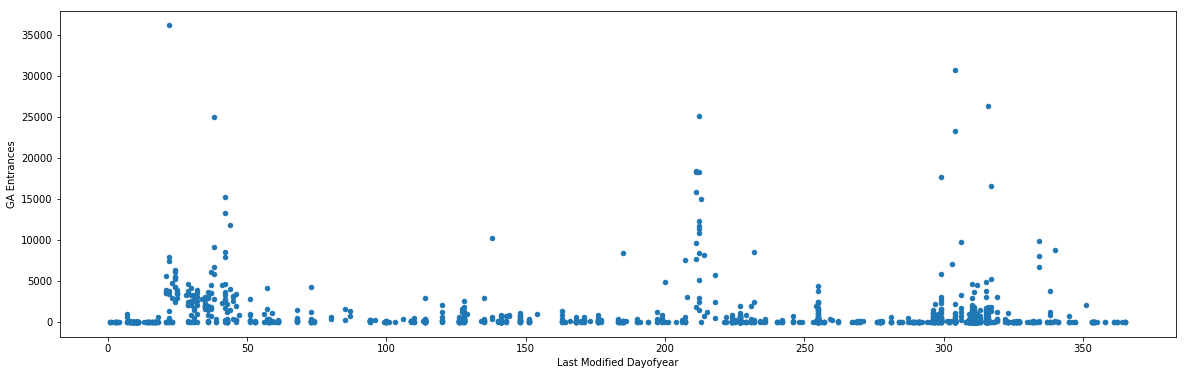

In [35]:
df_train_p2.plot(kind='scatter', x='Last Modified Dayofyear', y='GA Entrances', figsize=(20,6))
#On some specific days, a lot of content was publshed
#it looks like around the 25 to 35 and then again the 300 to 320 mark the content did well

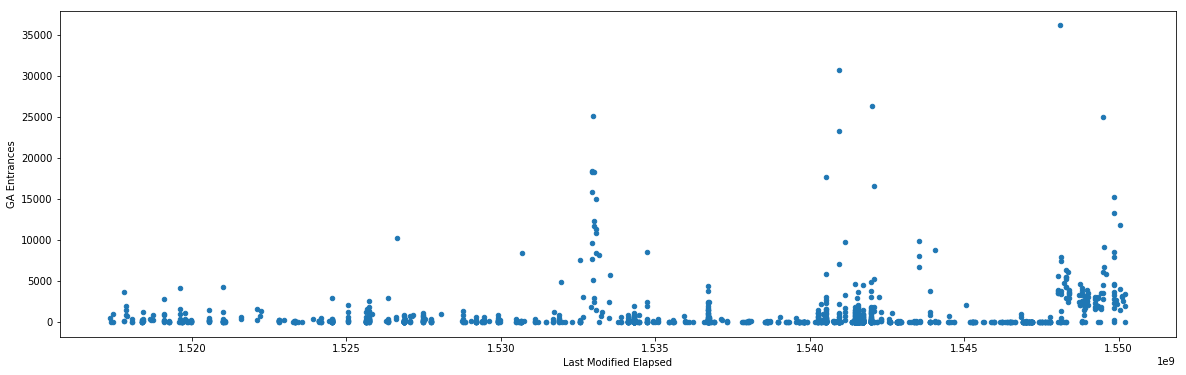

In [36]:
df_train_p2.plot(kind='scatter', x='Last Modified Elapsed', y='GA Entrances', figsize=(20,6))
#Elapsed represents how many days are elapsed since January 1st, 1970
#So looking at graph we are saying newer content is getting more traffic

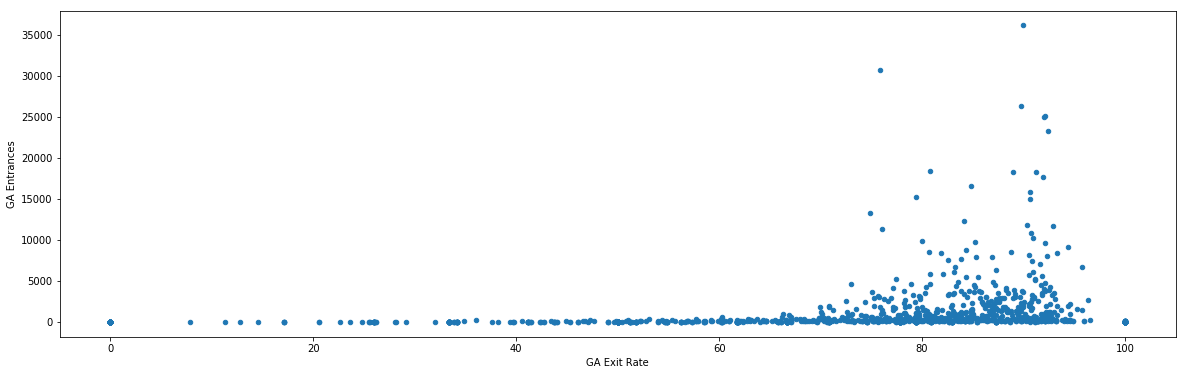

In [37]:
df_train_p2.plot(kind='scatter', x='GA Exit Rate', y='GA Entrances', figsize=(20,6))
#appears to be a relationship.  Pages with high exit rates, attract more traffic.  Could be that because they are well written, users get what they need and leave.


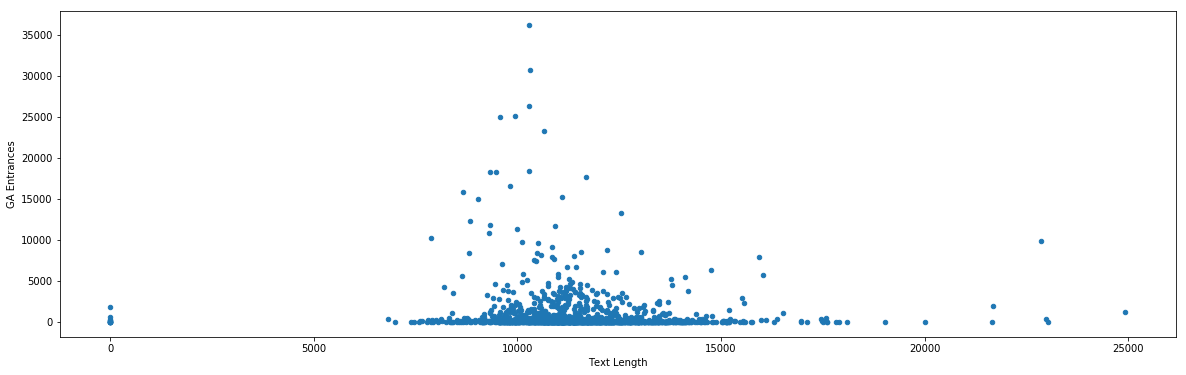

In [38]:
df_train_p2.plot(kind='scatter', x='Text Length', y='GA Entrances', figsize=(20,6))
#certainly remove the 0's here.
#can also remove the huge ones above 20k words
#again appears to be a happy medium around 10,000 words. surprised this is not a better predictor

In [39]:
df_train_p2 = df_train_p2[(df_train_p2['Text Length'] > 0)] #removing pages with text length of 0
df_train_p2 = df_train_p2[(df_train_p2['Text Length'] < 20000)] #removing huge pages as well

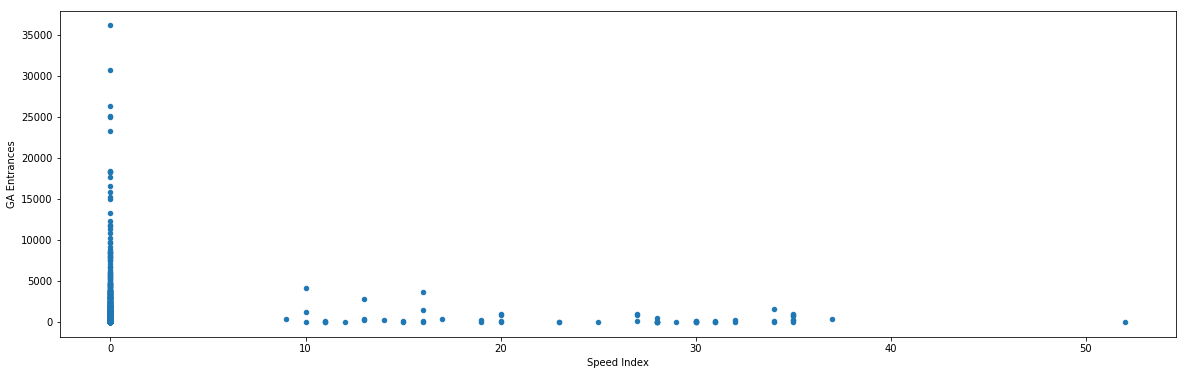

In [40]:
df_train_p2.plot(kind='scatter', x='Speed Index', y='GA Entrances', figsize=(20,6))
#appear to be a lot of pages without a speed score.  probably just missing data. but worth looking into.

In [41]:
df_train_p2['Speed Index'].value_counts()

0.0     1347
35.0       6
28.0       6
30.0       5
20.0       4
16.0       4
34.0       3
11.0       3
10.0       3
13.0       3
31.0       3
27.0       3
15.0       2
32.0       2
19.0       2
23.0       2
25.0       1
17.0       1
52.0       1
12.0       1
37.0       1
14.0       1
29.0       1
9.0        1
Name: Speed Index, dtype: int64

In [42]:
#save df_train_p2 for feather for later
df_train_p2_feather = df_train_p2.copy() #leave original intact before we change the index for feather csv
df_train_p2_feather.reset_index(inplace=True) #have to do this for feather to save it as a csv, since the index is not aligned
import feather
df_train_p2_feather.to_feather('df_train_p2')

In [43]:
df_train_p2_feather.head()

,index,TLD,Scheme,HTTP Status Code,Content Type,Content Length,Charset,Encoding,HTML Length,Text Length,...,Last Modified Is_month_start,Last Modified Is_quarter_end,Last Modified Is_quarter_start,Last Modified Is_year_end,Last Modified Is_year_start,Last Modified Hour,Last Modified Minute,Last Modified Second,Last Modified Elapsed,GA Time on Page
0,2975,au,https,200,"text/html; charset=""UTF-8""",95140.0,"""UTF-8""",utf-8,81707,13433,...,False,False,False,False,False,2,37,0,1517366220,270.0
1,2976,au,https,200,"text/html; charset=""UTF-8""",92732.0,"""UTF-8""",utf-8,81433,11299,...,False,False,False,False,False,6,28,0,1517380080,28.0
2,2977,au,https,200,"text/html; charset=""UTF-8""",91641.0,"""UTF-8""",utf-8,81082,10559,...,True,False,False,False,False,0,33,0,1517445180,292.0
3,2978,au,https,200,"text/html; charset=""UTF-8""",90789.0,"""UTF-8""",utf-8,80978,9811,...,True,False,False,False,False,3,4,0,1517454240,106.0
4,2979,au,https,200,"text/html; charset=""UTF-8""",92611.0,"""UTF-8""",utf-8,81190,11421,...,False,False,False,False,False,0,59,0,1517792340,223.0


In [71]:
#lets run the algo again after all these changes.

In [99]:
df_train_p2.info(verbose=True)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1414 entries, 0 to 1413
Data columns (total 173 columns):
index                                                   int64
TLD                                                     object
Scheme                                                  object
HTTP Status Code                                        int64
Content Type                                            object
Content Length                                          float64
Charset                                                 object
Encoding                                                object
HTML Length                                             int64
Text Length                                             int64
Text to HTML Ratio                                      float64
Title                                                   object
Title Length                                            int64
Description                                             object
Description L

In [52]:
train_cats(df_train_p2)
#apply_cats(X_test, trn=X_train)

In [65]:
#proc df on both train and test after the above

In [66]:
#seems that most people do proc_df before splitting into train/test/split
df, y , nas = proc_df(df_train_p2, 'GA Entrances', max_n_cat=None)
#X_test,y_test,nas = proc_df(X_test, 'GA Entrances', na_dict=nas)  #only in this case, since we have actual data, but usually on a validation set, we wouldn't keep the 'item_count_day'
#X, y , nas = proc_df(df_train, 'item_cnt_day', na_dict=nas)

In [67]:
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(df, y, test_size=0.2, random_state=42) #dont actually need the 'y' at this stage, just using it to make this work.

In [68]:
#checking the shapes look right.
df_train_p2.shape, X_train.shape, y_train.shape, X_test.shape, y_test.shape

((1414, 172), (1131, 209), (1131,), (283, 209), (283,))

In [69]:
#fit random forest to the data
#set_rf_samples(3000)

from sklearn.ensemble import RandomForestRegressor
rf = RandomForestRegressor(n_estimators=50, max_depth = 20, min_samples_leaf=4, max_features=0.5, n_jobs=-1, oob_score=True)

%time rf_fit = rf.fit(X_train, y_train)
rf_predict = rf_fit.predict(X_test) #predictions

#calculate Root Mean Squared Error for predictions 'rf_predict' against actuals 'y_test'
from sklearn.metrics import mean_squared_error
mse = mean_squared_error(y_test, rf_predict)
rmsqe = np.sqrt(mse)
print("RMSQE: ", rmsqe)

Wall time: 513 ms
RMSQE:  1293.3741985310985


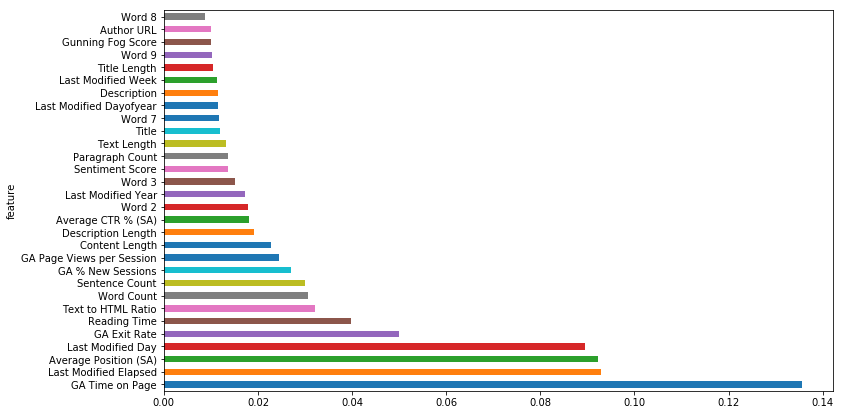

In [70]:
feat_labels = X_train.columns
importance = rf_fit.feature_importances_  #determing feature importance from the algorithm"

df_feat = pd.DataFrame(importance, index=feat_labels)
df_feat = df_feat.reset_index()
df_feat = df_feat.rename(index=str, columns={0: "importance", 'index': 'feature'})
df_feat = df_feat.sort_values('importance', ascending=False, inplace=False, axis=0)
df_feat.head(20)

#plotting feature importances
def plot_fi(df): 
  return df.plot('feature','importance','barh', figsize=(12,7), legend=False)
plot_fi(df_feat[:30]);


In [71]:
to_keep = df_feat[df_feat.importance>0.01].feature; len(to_keep)
df_keep = df[to_keep].copy()  #df is the original df where we did proc_df

X_train, X_test, y_train, y_test = train_test_split(df_keep, y, test_size=0.2, random_state=42)

df_keep.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1414 entries, 2975 to 4435
Data columns (total 28 columns):
GA Time on Page              1414 non-null float64
Last Modified Elapsed        1414 non-null int64
Average Position (SA)        1414 non-null float64
Last Modified Day            1414 non-null int64
GA Exit Rate                 1414 non-null float64
Reading Time                 1414 non-null int16
Text to HTML Ratio           1414 non-null float64
Word Count                   1414 non-null int64
Sentence Count               1414 non-null int64
GA % New Sessions            1414 non-null float64
GA Page Views per Session    1414 non-null float64
Content Length               1414 non-null float64
Description Length           1414 non-null int64
Average CTR % (SA)           1414 non-null float64
Word 2                       1414 non-null int16
Last Modified Year           1414 non-null int64
Word 3                       1414 non-null int16
Sentiment Score              1414 non-nul

In [72]:
from sklearn.ensemble import RandomForestRegressor
rf = RandomForestRegressor(n_estimators=50, max_depth = 20, min_samples_leaf=6, max_features=0.5, n_jobs=-1, oob_score=True)

%time rf_fit = rf.fit(X_train, y_train)
rf_predict = rf_fit.predict(X_test) #predictions

#calculate Root Mean Squared Error for predictions 'rf_predict' against actuals 'y_test'
from sklearn.metrics import mean_squared_error
mse = mean_squared_error(y_test, rf_predict)
rmsqe = np.sqrt(mse)
print("RMSQE: ", rmsqe)

Wall time: 272 ms
RMSQE:  1290.6607256618784


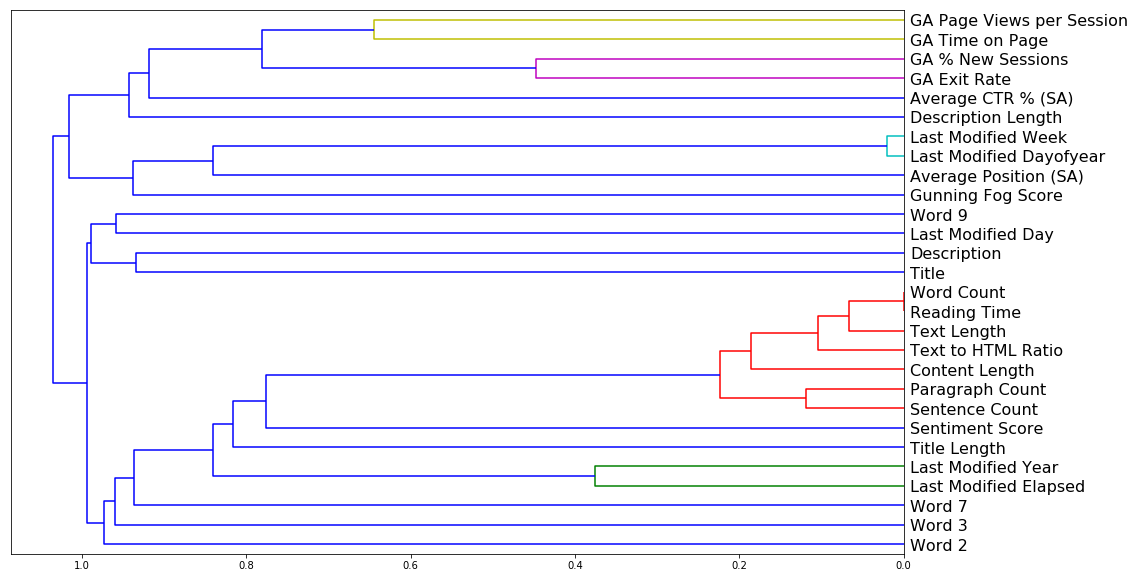

In [73]:
#cluster analysis to further find variables that are too similar using correlation between variables.
from scipy.cluster import hierarchy as hc
corr = np.round(scipy.stats.spearmanr(df_keep).correlation, 4)
corr_condensed = hc.distance.squareform(1-corr)
z = hc.linkage(corr_condensed, method='average')
fig = plt.figure(figsize=(16,10))
dendrogram = hc.dendrogram(z, labels=df_keep.columns, 
      orientation='left', leaf_font_size=16)
plt.show()
#things  closer to the right like fireplaces are variables are similar and need to be investigatedfurther

In [74]:
#drop these because they are too similar
to_drop = ['Reading Time', 'Text Length', 'Text to HTML Ratio', 'Content Length']

df_keep.drop(to_drop, axis=1, inplace=True)
X_train, X_test, y_train, y_test = train_test_split(df_keep, y, test_size=0.2, random_state=42)

from sklearn.ensemble import RandomForestRegressor
rf = RandomForestRegressor(n_estimators=50, max_depth = 20, 
min_samples_leaf=6, max_features=0.5, n_jobs=-1, oob_score=True)

%time rf_fit = rf.fit(X_train, y_train)
rf_predict = rf_fit.predict(X_test) #predictions

#calculate Root Mean Squared Error for predictions 'rf_predict' against actuals 'y_test'
from sklearn.metrics import mean_squared_error
mse = mean_squared_error(y_test, rf_predict)
rmsqe = np.sqrt(mse)
print("RMSQE: ", rmsqe)

Wall time: 149 ms
RMSQE:  1245.2183242409094


In [75]:
df_keep.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1414 entries, 2975 to 4435
Data columns (total 24 columns):
GA Time on Page              1414 non-null float64
Last Modified Elapsed        1414 non-null int64
Average Position (SA)        1414 non-null float64
Last Modified Day            1414 non-null int64
GA Exit Rate                 1414 non-null float64
Word Count                   1414 non-null int64
Sentence Count               1414 non-null int64
GA % New Sessions            1414 non-null float64
GA Page Views per Session    1414 non-null float64
Description Length           1414 non-null int64
Average CTR % (SA)           1414 non-null float64
Word 2                       1414 non-null int16
Last Modified Year           1414 non-null int64
Word 3                       1414 non-null int16
Sentiment Score              1414 non-null int64
Paragraph Count              1414 non-null int64
Title                        1414 non-null int16
Word 7                       1414 non-null in

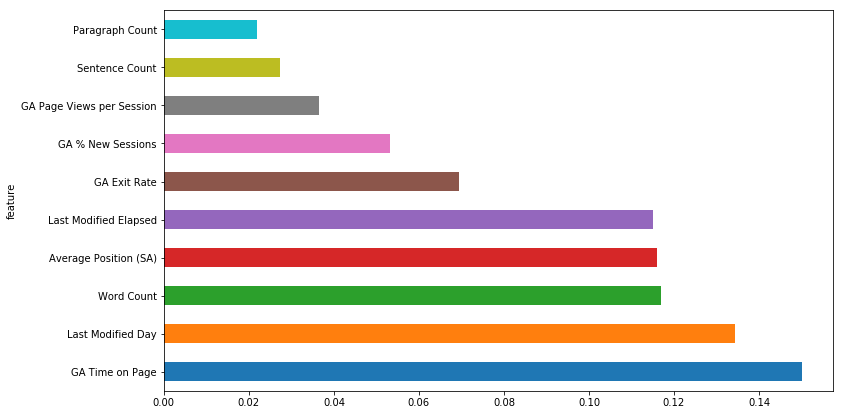

In [76]:
feat_labels = X_train.columns
importance = rf_fit.feature_importances_  #determing feature importance from the algorithm"

df_feat = pd.DataFrame(importance, index=feat_labels)
df_feat = df_feat.reset_index()
df_feat = df_feat.rename(index=str, columns={0: "importance", 'index': 'feature'})
df_feat = df_feat.sort_values('importance', ascending=False, inplace=False, axis=0)
df_feat.head(20)

#plotting feature importances
def plot_fi(df): 
  return df.plot('feature','importance','barh', figsize=(12,7), legend=False)
plot_fi(df_feat[:10]);

# 4b. review the mean again

In [77]:
#----
#what would happen if we predicted the average  for everything?
X_train['avg_GA_entrances'] = y_train.mean() #find the mean and create a new column in the training set.
X_train['avg_GA_entrances'].head()

C:\Users\Mark\Anaconda3\envs\fastai\lib\site-packages\ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  This is separate from the ipykernel package so we can avoid doing imports until


3621    864.914235
3761    864.914235
3472    864.914235
3026    864.914235
3135    864.914235
Name: avg_GA_entrances, dtype: float64

In [78]:
y_test.shape #work out how many rows in the test set

(283,)

In [79]:
y_avg_cnt = X_train['avg_GA_entrances'][:283].values #creat an array of that length

mse = mean_squared_error(y_test, y_avg_cnt)
rmsqe = np.sqrt(mse)
print("RMSQE: ", rmsqe) 

RMSQE:  1605.713357789781


# 5. Convert to classifier problem

In [80]:
df_train_p3 = df_train_p2.copy()

In [81]:
df_train_p3['GA Entrances'].describe()

count     1414.000000
mean       829.574965
std       2648.610694
min          0.000000
25%          7.000000
50%         55.000000
75%        381.250000
max      36146.000000
Name: GA Entrances, dtype: float64

In [82]:
df_train_p2['GA Entrances'].median()

55.0

In [83]:
#let's take anything above 200 visitors as good (roughly splits 2/3 as bad)
df_train_p3['GA Entrances'] = np.where(df_train_p3['GA Entrances']>=55, 1, 0) #convert into 1 or 0, ie yes/no ie classifier
df_train_p3['GA Entrances'].value_counts()

1    714
0    700
Name: GA Entrances, dtype: int64

In [84]:
#prepare for algorith
df, y , nas = proc_df(df_train_p3, 'GA Entrances', max_n_cat=None)

In [85]:
X_train, X_test, y_train, y_test = train_test_split(df, y, test_size=0.2, random_state=42)

In [86]:
df_train_p3.shape, X_train.shape, y_train.shape, X_test.shape, y_test.shape

((1414, 172), (1131, 209), (1131,), (283, 209), (283,))

In [87]:
from sklearn.ensemble import RandomForestClassifier
rfc = RandomForestClassifier(n_estimators=50, max_depth = 20, 
min_samples_leaf=4, max_features=0.5, n_jobs=-1, oob_score=True)

%time rfc_fit = rfc.fit(X_train, y_train)
rfc_predict = rfc_fit.predict(X_test) #predictions

from sklearn.metrics import accuracy_score
y_pred = rfc_fit.predict(X_test)
print("full rfc accuracy score: ",accuracy_score(y_test, y_pred))

Wall time: 402 ms
full rfc accuracy score:  0.9257950530035336


In [88]:
from sklearn.metrics import confusion_matrix
confusion_matrix(y_test, y_pred)
#first row is the negative class: true negative (correctly classified as incorrect (no conversion)), false positives (wrongly classified as correct (thinks there is a conversion, when there shouldnt be))
#2nd row is the positive class: False negatives (wrongly classifed as incorrect (thinks there isnt a conversion but there should be)), True positives (correctly classifed as correct, (correctly classifed as a conversion))
# a perfect classifier would have only true positives and true negatives (says 0 when no conversion and 1 when there is a conversion)

array([[123,   8],
       [ 13, 139]], dtype=int64)

In [89]:
from sklearn.metrics import precision_score, recall_score
print("Precision: ", precision_score(y_test, y_pred))  #this could also be done for Y_test and predictions 
print("recall: ", recall_score(y_test, y_pred))

#precision means when it makes a claim it is only correct x% of the time (% of times it got it right when it claimed (1) a conversion)
#recall means it only detects x% of the right answers (% of times it got it right when it claimed (0) not a conversion)

from sklearn.metrics import f1_score
print("f1_score: ", f1_score(y_test, y_pred))

#F1 score is the harmonic mean of precision and recall, good for comparing classifers, but favours calssiferiers with similar precision and recall, which is not always what you want.

Precision:  0.9455782312925171
recall:  0.9144736842105263
f1_score:  0.9297658862876254


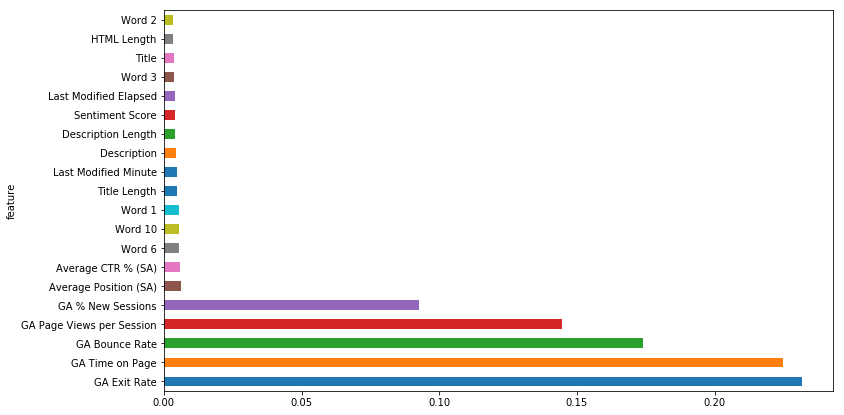

In [90]:
feat_labels = X_train.columns
importance = rfc_fit.feature_importances_  #determing feature importance from the algorithm"

df_feat = pd.DataFrame(importance, index=feat_labels)
df_feat = df_feat.reset_index()
df_feat = df_feat.rename(index=str, columns={0: "importance", 'index': 'feature'})
df_feat = df_feat.sort_values('importance', ascending=False, inplace=False, axis=0)
df_feat.head(20)

#plotting feature importances
def plot_fi(df): 
  return df.plot('feature','importance','barh', figsize=(12,7), legend=False)
plot_fi(df_feat[:20]);

In [91]:
to_keep = df_feat[df_feat.importance>0.01].feature; len(to_keep)
df_keep = df[to_keep].copy()  #df is the original df where we did proc_df

X_train, X_test, y_train, y_test = train_test_split(df_keep, y, test_size=0.2, random_state=42)

df_keep.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1414 entries, 2975 to 4435
Data columns (total 5 columns):
GA Exit Rate                 1414 non-null float64
GA Time on Page              1414 non-null float64
GA Bounce Rate               1414 non-null float64
GA Page Views per Session    1414 non-null float64
GA % New Sessions            1414 non-null float64
dtypes: float64(5)
memory usage: 66.3 KB


In [92]:
from sklearn.ensemble import RandomForestClassifier
rfc = RandomForestClassifier(n_estimators=50, max_depth = 20, 
min_samples_leaf=4, max_features=0.5, n_jobs=-1, oob_score=True)

%time rfc_fit = rfc.fit(X_train, y_train)
rfc_predict = rfc_fit.predict(X_test) #predictions

from sklearn.metrics import accuracy_score
y_pred = rfc_fit.predict(X_test)
print("full rfc accuracy score: ",accuracy_score(y_test, y_pred))

Wall time: 160 ms
full rfc accuracy score:  0.9293286219081273


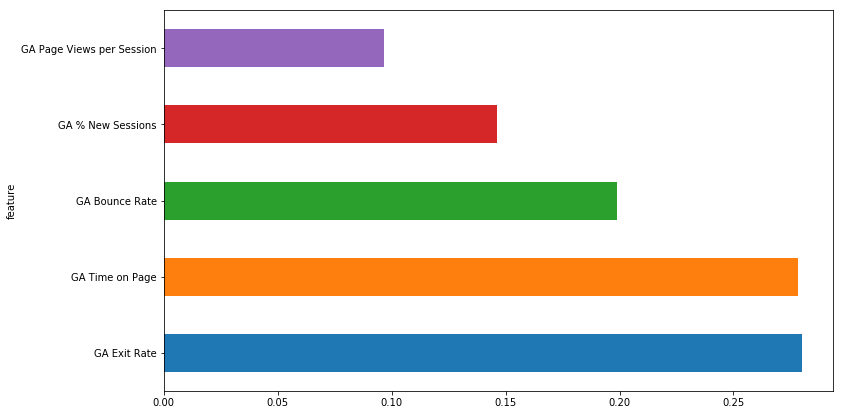

In [93]:
feat_labels = X_train.columns
importance = rfc_fit.feature_importances_  #determing feature importance from the algorithm"

df_feat = pd.DataFrame(importance, index=feat_labels)
df_feat = df_feat.reset_index()
df_feat = df_feat.rename(index=str, columns={0: "importance", 'index': 'feature'})
df_feat = df_feat.sort_values('importance', ascending=False, inplace=False, axis=0)
df_feat.head(20)

#plotting feature importances
def plot_fi(df): 
  return df.plot('feature','importance','barh', figsize=(12,7), legend=False)
plot_fi(df_feat[:20]);

# 5b. classifer predicting just 0's

In [94]:
#-check regarding what would happen if just predicting NO entrances for everything
X_train['NO_GA_entrances'] = 0 #find the mean and create a new column in the training set.
X_train['NO_GA_entrances'].head()

C:\Users\Mark\Anaconda3\envs\fastai\lib\site-packages\ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  


3621    0
3761    0
3472    0
3026    0
3135    0
Name: NO_GA_entrances, dtype: int64

In [95]:
y_test.shape #work out how many rows in the test set

(283,)

In [96]:
y_no_entrances = X_train['NO_GA_entrances'][:283].values

In [97]:
from sklearn.metrics import accuracy_score
print("full rf_c accuracy score: ",accuracy_score(y_test, y_no_entrances))
#so the random forest is still better
#if we just guess that all pages will get lower then average vists (less then 200 visits) we will be right 64% of time.  RF will be right 89% of the time

full rf_c accuracy score:  0.4628975265017668


In [98]:
from sklearn.metrics import confusion_matrix
confusion_matrix(y_test,  y_no_entrances)

array([[131,   0],
       [152,   0]], dtype=int64)

In [99]:
#plot feature importance for the classifier.

In [100]:
#at this point after running the intro and Part2, df_keep is too refined, as it has to few parameters. (because neural networks combine features) 
#df_train_p2 is less refined - this should be the one to use and it has the y value in the DF as well.
#df_train is even less, its the rawest version

# 6. Neural Networks

In [101]:
#--- going through these articles: 

#https://machinelearningmastery.com/tutorial-first-neural-network-python-keras/
#https://machinelearningmastery.com/custom-metrics-deep-learning-keras-python/ - for loss functions
#https://machinelearningmastery.com/how-to-make-classification-and-regression-predictions-for-deep-learning-models-in-keras/
#https://towardsdatascience.com/deep-neural-networks-for-regression-problems-81321897ca33
#https://machinelearningmastery.com/regression-tutorial-keras-deep-learning-library-python/
#https://medium.com/@robertjohn_15390/simple-housing-price-prediction-using-neural-networks-with-tensorflow-8b486d3db3ca

In [119]:
import feather
#df_train_read = pd.read_feather('test') #this didnt work
df_train_p2 = feather.read_dataframe('df_train_p2')

In [83]:
df_train_p2.info(verbose=True)

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1414 entries, 2975 to 4435
Data columns (total 172 columns):
TLD                                                     object
Scheme                                                  object
HTTP Status Code                                        int64
Content Type                                            object
Content Length                                          float64
Charset                                                 object
Encoding                                                object
HTML Length                                             int64
Text Length                                             int64
Text to HTML Ratio                                      float64
Title                                                   object
Title Length                                            int64
Description                                             object
Description Length                                      int64
Word Count

# 6a. Neural Network Regression - deep

In [84]:
df_part_nn = df_train_p2.copy()  #note train_cats was already performed on df_train_p2

In [85]:
train_cats(df_part_nn)

In [86]:
#proc_df but this time with a scaler (this is like min/max scaler to make all values between 0 & 1 which is much better for gradient descent & other optimizers)
#there is no need to scale the target variable (y)
df, y , nas, mapper = proc_df(df_part_nn, 'GA Entrances', do_scale=True) #added the scaling, since this is important for neural networks
#we could've also scaled the x_train, y_train data after proc_df I guess, but this is easier as they are all together

In [87]:
X_train, X_test, y_train, y_test = train_test_split(df, y, test_size=0.2, random_state=42)

In [88]:
X_train.info() #the number of entries should define the input layer of the network

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1131 entries, 3621 to 4129
Columns: 209 entries, TLD to First Contentful Paint (3G)_na
dtypes: float64(157), int16(13), int8(39)
memory usage: 1.4 MB


In [89]:
#def mean_squared_error(y_true, y_pred):
   # return K.mean(K.square(y_pred - y_true), axis=-1)

In [90]:
#if want to use RMSE, need to define it, see here: https://machinelearningmastery.com/custom-metrics-deep-learning-keras-python/
from keras import backend
 
def rmse(y_true, y_pred):
    return backend.sqrt(backend.mean(backend.square(y_pred - y_true), axis=-1))

In [91]:
#create the NN model & compile

NN_model = Sequential()

# The Input Layer :
NN_model.add(Dense(400, kernel_initializer='normal',input_dim = X_train.shape[1], activation='relu'))

# The Hidden Layers :
NN_model.add(Dense(200, kernel_initializer='normal',activation='relu'))
NN_model.add(Dense(200, kernel_initializer='normal',activation='relu'))
NN_model.add(Dense(100, kernel_initializer='normal',activation='relu'))

# The Output Layer :
NN_model.add(Dense(1, kernel_initializer='normal')) #,activation='linear' is often used for regression 

# Compile the network :
NN_model.compile(loss='mean_squared_error', optimizer='adam', metrics=['mse', 'mae', rmse])
NN_model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_28 (Dense)             (None, 400)               84000     
_________________________________________________________________
dense_29 (Dense)             (None, 200)               80200     
_________________________________________________________________
dense_30 (Dense)             (None, 200)               40200     
_________________________________________________________________
dense_31 (Dense)             (None, 100)               20100     
_________________________________________________________________
dense_32 (Dense)             (None, 1)                 101       
Total params: 224,601
Trainable params: 224,601
Non-trainable params: 0
_________________________________________________________________


In [107]:
# Set callback functions to early stop training and save the best model so far
callbacks = [EarlyStopping(monitor='mean_squared_error', patience=20),
             ModelCheckpoint(filepath='best_model.h5', monitor='mean_squared_error', save_best_only=True)]
#patience is the number of epochs to look back for non-improvement.
#modelcheckpoint saves the best perfoming epoch rather then the one it finished on
#well explained here: https://chrisalbon.com/deep_learning/keras/neural_network_early_stopping/

In [108]:
%time history = NN_model.fit(X_train,y_train, epochs=200, batch_size=15, callbacks=callbacks, validation_split = 0.2, verbose=2) 

#pyplot.plot(history.history['mean_squared_error'], label='MSE')
#pyplot.plot(history.history['mean_absolute_error'], label='MAE')

Train on 904 samples, validate on 227 samples
Epoch 1/200
 - 0s - loss: 1080554.8100 - mean_squared_error: 1080554.8100 - mean_absolute_error: 483.3124 - rmse: 483.3124 - val_loss: 19348814.7742 - val_mean_squared_error: 19348814.7742 - val_mean_absolute_error: 1435.5395 - val_rmse: 1435.5395
Epoch 2/200
 - 0s - loss: 769150.9970 - mean_squared_error: 769150.9970 - mean_absolute_error: 392.3592 - rmse: 392.3592 - val_loss: 18797214.5374 - val_mean_squared_error: 18797214.5374 - val_mean_absolute_error: 1368.4594 - val_rmse: 1368.4594
Epoch 3/200
 - 0s - loss: 671494.1812 - mean_squared_error: 671494.1812 - mean_absolute_error: 374.8433 - rmse: 374.8433 - val_loss: 18628957.5762 - val_mean_squared_error: 18628957.5762 - val_mean_absolute_error: 1378.2705 - val_rmse: 1378.2705
Epoch 4/200
 - 0s - loss: 501180.7443 - mean_squared_error: 501180.7443 - mean_absolute_error: 349.8911 - rmse: 349.8911 - val_loss: 18409623.8252 - val_mean_squared_error: 18409623.8252 - val_mean_absolute_error: 

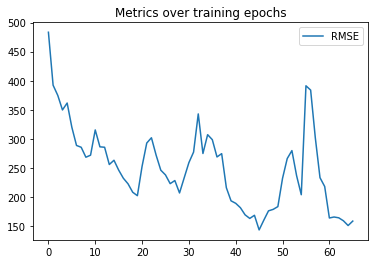

In [109]:
pyplot.plot(history.history['rmse'], label='RMSE')
plt.title('Metrics over training epochs')
plt.legend()
pyplot.show()

In [110]:
predictions = NN_model.predict(X_test)  #for classification it would be model.predict_classes(Xnew)
print(predictions)

[[ 566.8506 ]
 [ 261.7096 ]
 [  44.10794]
 [5300.9214 ]
 [ 120.74677]
 [  27.59987]
 [1030.1809 ]
 [1081.2717 ]
 [ 172.87851]
 [  86.0322 ]
 [ 126.13319]
 [ 235.32248]
 [  11.5534 ]
 [ 746.8806 ]
 [1309.5051 ]
 [ 511.57562]
 [ 164.78375]
 [ 113.23036]
 [ 102.69559]
 [  55.13816]
 [ 125.60178]
 [ -12.73927]
 [  74.47063]
 [ 118.26111]
 [ 322.95648]
 [  80.36887]
 [1406.8479 ]
 [1571.5406 ]
 [  52.3736 ]
 [ 598.03284]
 [ 343.59567]
 [2139.4836 ]
 [ 740.82056]
 [ -31.87165]
 [ 685.2534 ]
 [  59.90962]
 [3593.1694 ]
 [ 363.16696]
 [ 121.27574]
 [ 238.97287]
 [  57.7303 ]
 [  40.67373]
 [  56.58074]
 [ 362.4143 ]
 [ 131.23843]
 [2818.2732 ]
 [  72.18117]
 [2529.2625 ]
 [  97.46853]
 [1146.0519 ]
 [ 107.00158]
 [ 129.6317 ]
 [  13.974  ]
 [ 158.98769]
 [ 382.31854]
 [ 120.29811]
 [  37.05239]
 [  32.24016]
 [ 128.95079]
 [ 114.93494]
 [  68.27729]
 [ 160.63954]
 [  27.56547]
 [ 149.18372]
 [  77.41479]
 [ 136.87677]
 [ 347.14993]
 [  68.67024]
 [  72.78895]
 [ 119.00513]
 [ 127.03801]
 [  41

In [111]:
score = NN_model.evaluate(X_test, y_test, verbose=0)
print(score)

[2549235.3321554773, 2549235.3321554773, 730.9555597204202, 730.9555666219219]


In [112]:
from sklearn.metrics import mean_squared_error
mse = mean_squared_error(y_test, predictions)
rmsqe = np.sqrt(mse)
print("MSE: ", mse)
print("RMSQE: ", rmsqe)

MSE:  2549235.397978218
RMSQE:  1596.6325181387913


# 4b NN regression shallower & wider model

In [72]:
#create the NN model & compile

#keras.backend.clear_session() #dont think you need it but I put it here just in case.
    
NN_model2 = Sequential()

# The Input Layer :
NN_model2.add(Dense(500, kernel_initializer='normal',input_dim = X_train.shape[1], activation='relu'))

# The Hidden Layer :
NN_model2.add(Dense(400, kernel_initializer='normal',activation='relu'))

# The Output Layer :
NN_model2.add(Dense(1, kernel_initializer='normal')) #,activation='linear' #i think you use sigmoid on last layer if its a classifier

# Compile the network :
NN_model2.compile(loss='mean_squared_error', optimizer='adam', metrics=['mse', 'mae', rmse])
NN_model2.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_20 (Dense)             (None, 600)               126000    
_________________________________________________________________
dense_21 (Dense)             (None, 400)               240400    
_________________________________________________________________
dense_22 (Dense)             (None, 1)                 401       
Total params: 366,801
Trainable params: 366,801
Non-trainable params: 0
_________________________________________________________________


In [113]:
%time history = NN_model2.fit(X_train,y_train, epochs=200, batch_size=15, callbacks=callbacks, validation_split = 0.2, verbose=2)

Train on 904 samples, validate on 227 samples
Epoch 1/200
 - 0s - loss: 25271.1706 - mean_squared_error: 25271.1706 - mean_absolute_error: 89.5818 - rmse: 89.5818 - val_loss: 17836298.7589 - val_mean_squared_error: 17836298.7589 - val_mean_absolute_error: 1477.0821 - val_rmse: 1477.0821
Epoch 2/200
 - 0s - loss: 56717.6663 - mean_squared_error: 56717.6663 - mean_absolute_error: 127.5737 - rmse: 127.5737 - val_loss: 17401766.1479 - val_mean_squared_error: 17401766.1479 - val_mean_absolute_error: 1449.3495 - val_rmse: 1449.3495
Epoch 3/200
 - 0s - loss: 115135.6951 - mean_squared_error: 115135.6951 - mean_absolute_error: 163.9650 - rmse: 163.9650 - val_loss: 17349499.0589 - val_mean_squared_error: 17349499.0589 - val_mean_absolute_error: 1505.1436 - val_rmse: 1505.1436
Epoch 4/200
 - 0s - loss: 228404.7298 - mean_squared_error: 228404.7298 - mean_absolute_error: 232.2888 - rmse: 232.2888 - val_loss: 16994550.1108 - val_mean_squared_error: 16994550.1108 - val_mean_absolute_error: 1415.155

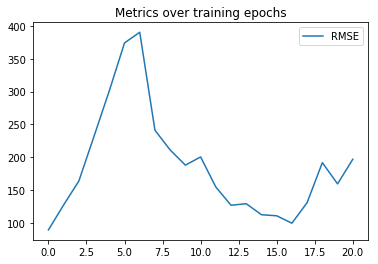

In [114]:
pyplot.plot(history.history['rmse'], label='RMSE')
plt.title('Metrics over training epochs')
plt.legend()
pyplot.show()

In [115]:
predictions = NN_model2.predict(X_test)  #for classification it would be model.predict_classes(Xnew)
print(predictions)

[[1043.1626 ]
 [ 138.70346]
 [-142.21634]
 [1775.3251 ]
 [ 527.146  ]
 [ 958.59106]
 [1138.3219 ]
 [ 208.97472]
 [ 450.1521 ]
 [ 386.8985 ]
 [  25.0987 ]
 [1116.4937 ]
 [ 210.25743]
 [ 870.8794 ]
 [2654.1924 ]
 [ 403.21274]
 [ 262.52554]
 [ 150.95543]
 [ 160.12505]
 [3981.2192 ]
 [ 673.588  ]
 [  78.2765 ]
 [  54.35256]
 [ 305.587  ]
 [ 457.5912 ]
 [ 486.75662]
 [ 893.2302 ]
 [ 497.37997]
 [-157.07248]
 [1396.2026 ]
 [4338.0444 ]
 [3005.3064 ]
 [1013.5923 ]
 [-998.0953 ]
 [ 817.31287]
 [ 207.48013]
 [2047.8276 ]
 [ 395.56113]
 [ 294.48407]
 [ 946.29395]
 [ 874.75525]
 [ 321.07443]
 [ 108.88442]
 [ 906.7022 ]
 [ 789.4258 ]
 [1826.9408 ]
 [ 329.31177]
 [2928.6792 ]
 [ 370.33923]
 [ 696.19696]
 [ 444.4897 ]
 [ 622.2187 ]
 [-265.42957]
 [  67.51823]
 [1086.7358 ]
 [ 346.39838]
 [ 133.44016]
 [ -61.23022]
 [ 139.35208]
 [ 571.58124]
 [ 502.2751 ]
 [ 507.57425]
 [-244.42032]
 [ 748.80347]
 [ 133.9504 ]
 [ 556.8394 ]
 [ 167.72234]
 [ 376.31882]
 [ 844.1398 ]
 [ 346.2861 ]
 [ 269.85458]
 [ 783

In [116]:
score = NN_model2.evaluate(X_test, y_test, verbose=0)
print(score)

[2574484.000883392, 2574484.000883392, 878.3570612715326, 878.3570612715326]


In [117]:
from sklearn.metrics import mean_squared_error
mse = mean_squared_error(y_test, predictions)
rmsqe = np.sqrt(mse)
print("MSE: ", mse)
print("RMSQE: ", rmsqe)

MSE:  2574484.004207831
RMSQE:  1604.5198671901296


# 4c NN categorical model

In [124]:
df_train_nn_cat = df_train_p2.copy()

In [125]:
#let's take anything above 200 visitors as good (roughly splits 2/3 as bad)
df_train_nn_cat['GA Entrances'] = np.where(df_train_nn_cat['GA Entrances']>=55, 1, 0) #convert into 1 or 0, ie yes/no ie classifier
df_train_nn_cat['GA Entrances'].value_counts()

1    714
0    700
Name: GA Entrances, dtype: int64

In [126]:
train_cats(df_train_nn_cat)

In [129]:
df, y , nas, mapper = proc_df(df_train_nn_cat, 'GA Entrances', do_scale=True)

In [130]:
X_train, X_test, y_train, y_test = train_test_split(df, y, test_size=0.2, random_state=42)

In [198]:
#categorical model
#create the NN model & compile

NN_model_cat = Sequential()

# The Input Layer :
NN_model_cat.add(Dense(400, input_dim = X_train.shape[1], activation='relu'))

# The Hidden Layers :
NN_model_cat.add(Dense(200, activation='relu'))

# The Output Layer :
NN_model_cat.add(Dense(1, activation='sigmoid')) #used softmax with 2 outputs for binary

# Compile the network :
NN_model_cat.compile(optimizer='adam', loss='binary_crossentropy', metrics=['acc']) #categorical_crossentropy - if more then 2 categories


In [199]:
callbacks = [EarlyStopping(monitor='binary_crossentropy', patience=20),
             ModelCheckpoint(filepath='best_model.h5', monitor='binary_crossentropy', save_best_only=True)]

In [200]:
%time history = NN_model_cat.fit(X_train, y_train, epochs=500, batch_size=30, callbacks=callbacks, validation_split = 0.2, verbose=2) 

Train on 904 samples, validate on 227 samples
Epoch 1/500
 - 1s - loss: 8.0288 - acc: 0.4945 - val_loss: 8.0765 - val_acc: 0.4934
Epoch 2/500
 - 0s - loss: 8.0065 - acc: 0.4978 - val_loss: 8.0765 - val_acc: 0.4934
Epoch 3/500
 - 0s - loss: 8.0065 - acc: 0.4978 - val_loss: 8.0765 - val_acc: 0.4934
Epoch 4/500
 - 0s - loss: 8.0065 - acc: 0.4978 - val_loss: 8.0765 - val_acc: 0.4934
Epoch 5/500
 - 0s - loss: 8.0065 - acc: 0.4978 - val_loss: 8.0765 - val_acc: 0.4934
Epoch 6/500
 - 0s - loss: 8.0065 - acc: 0.4978 - val_loss: 8.0765 - val_acc: 0.4934
Epoch 7/500
 - 0s - loss: 8.0065 - acc: 0.4978 - val_loss: 8.0765 - val_acc: 0.4934
Epoch 8/500
 - 0s - loss: 8.0065 - acc: 0.4978 - val_loss: 8.0765 - val_acc: 0.4934
Epoch 9/500
 - 0s - loss: 8.0065 - acc: 0.4978 - val_loss: 8.0765 - val_acc: 0.4934
Epoch 10/500
 - 0s - loss: 8.0065 - acc: 0.4978 - val_loss: 8.0765 - val_acc: 0.4934
Epoch 11/500
 - 0s - loss: 8.0065 - acc: 0.4978 - val_loss: 8.0765 - val_acc: 0.4934
Epoch 12/500
 - 0s - loss: 8

Epoch 97/500
 - 0s - loss: 8.0065 - acc: 0.4978 - val_loss: 8.0765 - val_acc: 0.4934
Epoch 98/500
 - 0s - loss: 8.0065 - acc: 0.4978 - val_loss: 8.0765 - val_acc: 0.4934
Epoch 99/500
 - 0s - loss: 8.0065 - acc: 0.4978 - val_loss: 8.0765 - val_acc: 0.4934
Epoch 100/500
 - 0s - loss: 8.0065 - acc: 0.4978 - val_loss: 8.0765 - val_acc: 0.4934
Epoch 101/500
 - 0s - loss: 8.0065 - acc: 0.4978 - val_loss: 8.0765 - val_acc: 0.4934
Epoch 102/500
 - 0s - loss: 8.0065 - acc: 0.4978 - val_loss: 8.0765 - val_acc: 0.4934
Epoch 103/500
 - 0s - loss: 8.0065 - acc: 0.4978 - val_loss: 8.0765 - val_acc: 0.4934
Epoch 104/500
 - 0s - loss: 8.0065 - acc: 0.4978 - val_loss: 8.0765 - val_acc: 0.4934
Epoch 105/500
 - 0s - loss: 8.0065 - acc: 0.4978 - val_loss: 8.0765 - val_acc: 0.4934
Epoch 106/500
 - 0s - loss: 8.0065 - acc: 0.4978 - val_loss: 8.0765 - val_acc: 0.4934
Epoch 107/500
 - 0s - loss: 8.0065 - acc: 0.4978 - val_loss: 8.0765 - val_acc: 0.4934
Epoch 108/500
 - 0s - loss: 8.0065 - acc: 0.4978 - val_lo

Epoch 193/500
 - 0s - loss: 8.0065 - acc: 0.4978 - val_loss: 8.0765 - val_acc: 0.4934
Epoch 194/500
 - 0s - loss: 8.0065 - acc: 0.4978 - val_loss: 8.0765 - val_acc: 0.4934
Epoch 195/500
 - 0s - loss: 8.0065 - acc: 0.4978 - val_loss: 8.0765 - val_acc: 0.4934
Epoch 196/500
 - 0s - loss: 8.0065 - acc: 0.4978 - val_loss: 8.0765 - val_acc: 0.4934
Epoch 197/500
 - 0s - loss: 8.0065 - acc: 0.4978 - val_loss: 8.0765 - val_acc: 0.4934
Epoch 198/500
 - 0s - loss: 8.0065 - acc: 0.4978 - val_loss: 8.0765 - val_acc: 0.4934
Epoch 199/500
 - 0s - loss: 8.0065 - acc: 0.4978 - val_loss: 8.0765 - val_acc: 0.4934
Epoch 200/500
 - 0s - loss: 8.0065 - acc: 0.4978 - val_loss: 8.0765 - val_acc: 0.4934
Epoch 201/500
 - 0s - loss: 8.0065 - acc: 0.4978 - val_loss: 8.0765 - val_acc: 0.4934
Epoch 202/500
 - 0s - loss: 8.0065 - acc: 0.4978 - val_loss: 8.0765 - val_acc: 0.4934
Epoch 203/500
 - 0s - loss: 8.0065 - acc: 0.4978 - val_loss: 8.0765 - val_acc: 0.4934
Epoch 204/500
 - 0s - loss: 8.0065 - acc: 0.4978 - val

Epoch 289/500
 - 0s - loss: 8.0065 - acc: 0.4978 - val_loss: 8.0765 - val_acc: 0.4934
Epoch 290/500
 - 0s - loss: 8.0065 - acc: 0.4978 - val_loss: 8.0765 - val_acc: 0.4934
Epoch 291/500
 - 0s - loss: 8.0065 - acc: 0.4978 - val_loss: 8.0765 - val_acc: 0.4934
Epoch 292/500
 - 0s - loss: 8.0065 - acc: 0.4978 - val_loss: 8.0765 - val_acc: 0.4934
Epoch 293/500
 - 0s - loss: 8.0065 - acc: 0.4978 - val_loss: 8.0765 - val_acc: 0.4934
Epoch 294/500
 - 0s - loss: 8.0065 - acc: 0.4978 - val_loss: 8.0765 - val_acc: 0.4934
Epoch 295/500
 - 0s - loss: 8.0065 - acc: 0.4978 - val_loss: 8.0765 - val_acc: 0.4934
Epoch 296/500
 - 0s - loss: 8.0065 - acc: 0.4978 - val_loss: 8.0765 - val_acc: 0.4934
Epoch 297/500
 - 0s - loss: 8.0065 - acc: 0.4978 - val_loss: 8.0765 - val_acc: 0.4934
Epoch 298/500
 - 0s - loss: 8.0065 - acc: 0.4978 - val_loss: 8.0765 - val_acc: 0.4934
Epoch 299/500
 - 0s - loss: 8.0065 - acc: 0.4978 - val_loss: 8.0765 - val_acc: 0.4934
Epoch 300/500
 - 0s - loss: 8.0065 - acc: 0.4978 - val

Epoch 385/500
 - 0s - loss: 8.0065 - acc: 0.4978 - val_loss: 8.0765 - val_acc: 0.4934
Epoch 386/500
 - 0s - loss: 8.0065 - acc: 0.4978 - val_loss: 8.0765 - val_acc: 0.4934
Epoch 387/500
 - 0s - loss: 8.0065 - acc: 0.4978 - val_loss: 8.0765 - val_acc: 0.4934
Epoch 388/500
 - 0s - loss: 8.0065 - acc: 0.4978 - val_loss: 8.0765 - val_acc: 0.4934
Epoch 389/500
 - 0s - loss: 8.0065 - acc: 0.4978 - val_loss: 8.0765 - val_acc: 0.4934
Epoch 390/500
 - 0s - loss: 8.0065 - acc: 0.4978 - val_loss: 8.0765 - val_acc: 0.4934
Epoch 391/500
 - 0s - loss: 8.0065 - acc: 0.4978 - val_loss: 8.0765 - val_acc: 0.4934
Epoch 392/500
 - 0s - loss: 8.0065 - acc: 0.4978 - val_loss: 8.0765 - val_acc: 0.4934
Epoch 393/500
 - 0s - loss: 8.0065 - acc: 0.4978 - val_loss: 8.0765 - val_acc: 0.4934
Epoch 394/500
 - 0s - loss: 8.0065 - acc: 0.4978 - val_loss: 8.0765 - val_acc: 0.4934
Epoch 395/500
 - 0s - loss: 8.0065 - acc: 0.4978 - val_loss: 8.0765 - val_acc: 0.4934
Epoch 396/500
 - 0s - loss: 8.0065 - acc: 0.4978 - val

Epoch 481/500
 - 0s - loss: 8.0065 - acc: 0.4978 - val_loss: 8.0765 - val_acc: 0.4934
Epoch 482/500
 - 0s - loss: 8.0065 - acc: 0.4978 - val_loss: 8.0765 - val_acc: 0.4934
Epoch 483/500
 - 0s - loss: 8.0065 - acc: 0.4978 - val_loss: 8.0765 - val_acc: 0.4934
Epoch 484/500
 - 0s - loss: 8.0065 - acc: 0.4978 - val_loss: 8.0765 - val_acc: 0.4934
Epoch 485/500
 - 0s - loss: 8.0065 - acc: 0.4978 - val_loss: 8.0765 - val_acc: 0.4934
Epoch 486/500
 - 0s - loss: 8.0065 - acc: 0.4978 - val_loss: 8.0765 - val_acc: 0.4934
Epoch 487/500
 - 0s - loss: 8.0065 - acc: 0.4978 - val_loss: 8.0765 - val_acc: 0.4934
Epoch 488/500
 - 0s - loss: 8.0065 - acc: 0.4978 - val_loss: 8.0765 - val_acc: 0.4934
Epoch 489/500
 - 0s - loss: 8.0065 - acc: 0.4978 - val_loss: 8.0765 - val_acc: 0.4934
Epoch 490/500
 - 0s - loss: 8.0065 - acc: 0.4978 - val_loss: 8.0765 - val_acc: 0.4934
Epoch 491/500
 - 0s - loss: 8.0065 - acc: 0.4978 - val_loss: 8.0765 - val_acc: 0.4934
Epoch 492/500
 - 0s - loss: 8.0065 - acc: 0.4978 - val

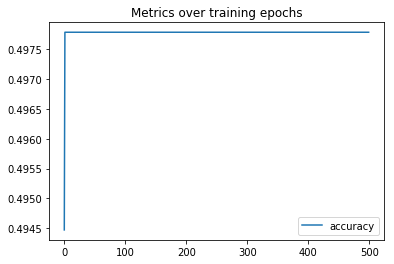

In [201]:
pyplot.plot(history.history['acc'], label='accuracy')
plt.title('Metrics over training epochs')
plt.legend()
pyplot.show()

In [202]:
predictions = NN_model_cat.predict_classes(X_test)  #for classification it would be model.predict_classes(Xnew)
print(predictions)

[[1]
 [1]
 [1]
 [1]
 [1]
 [1]
 [1]
 [1]
 [1]
 [1]
 [1]
 [1]
 [1]
 [1]
 [1]
 [1]
 [1]
 [1]
 [1]
 [1]
 [1]
 [1]
 [1]
 [1]
 [1]
 [1]
 [1]
 [1]
 [1]
 [1]
 [1]
 [1]
 [1]
 [1]
 [1]
 [1]
 [1]
 [1]
 [1]
 [1]
 [1]
 [1]
 [1]
 [1]
 [1]
 [1]
 [1]
 [1]
 [1]
 [1]
 [1]
 [1]
 [1]
 [1]
 [1]
 [1]
 [1]
 [1]
 [1]
 [1]
 [1]
 [1]
 [1]
 [1]
 [1]
 [1]
 [1]
 [1]
 [1]
 [1]
 [1]
 [1]
 [1]
 [1]
 [1]
 [1]
 [1]
 [1]
 [1]
 [1]
 [1]
 [1]
 [1]
 [1]
 [1]
 [1]
 [1]
 [1]
 [1]
 [1]
 [1]
 [1]
 [1]
 [1]
 [1]
 [1]
 [1]
 [1]
 [1]
 [1]
 [1]
 [1]
 [1]
 [1]
 [1]
 [1]
 [1]
 [1]
 [1]
 [1]
 [1]
 [1]
 [1]
 [1]
 [1]
 [1]
 [1]
 [1]
 [1]
 [1]
 [1]
 [1]
 [1]
 [1]
 [1]
 [1]
 [1]
 [1]
 [1]
 [1]
 [1]
 [1]
 [1]
 [1]
 [1]
 [1]
 [1]
 [1]
 [1]
 [1]
 [1]
 [1]
 [1]
 [1]
 [1]
 [1]
 [1]
 [1]
 [1]
 [1]
 [1]
 [1]
 [1]
 [1]
 [1]
 [1]
 [1]
 [1]
 [1]
 [1]
 [1]
 [1]
 [1]
 [1]
 [1]
 [1]
 [1]
 [1]
 [1]
 [1]
 [1]
 [1]
 [1]
 [1]
 [1]
 [1]
 [1]
 [1]
 [1]
 [1]
 [1]
 [1]
 [1]
 [1]
 [1]
 [1]
 [1]
 [1]
 [1]
 [1]
 [1]
 [1]
 [1]
 [1]
 [1]
 [1]
 [1]
 [1]
 [1]
 [1]


In [203]:
score = NN_model_cat.evaluate(X_test, y_test, verbose=0)
print(score)

[7.379690856057427, 0.5371024718132963]


In [204]:
from sklearn.metrics import accuracy_score
print("NN model acc score: " , accuracy_score(y_test, predictions))

NN model acc score:  0.5371024734982333
